# 課程重點
1. 使用驗證集驗證模型
2. 使用 sklearn.model_selection.cross_validate 執行交叉驗證
3. 使用 sklearn.model_selection.GridSearchCV 找出最佳模型超參數
4. 使用 sklearn.model_selection.validation_curve 觀察模型擬合狀況，是否有Overfitting / Underfitting

### Import Packages

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [7]:
train = pd.read_csv('/Users/kai/Desktop/FinTech Lab/108-2課程資料/bike_sharing_demand/data/train.csv') # 要改檔案路徑
test = pd.read_csv('/Users/kai/Desktop/FinTech Lab/108-2課程資料/bike_sharing_demand/data/test.csv') # 要改檔案路徑
print(train.shape)
train.head(10)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


### Select Features

In [8]:
features = ['holiday', 'workingday', 'atemp', 'humidity', 'windspeed']
x = train[features]
y = np.log(train['count'] + 1)
x.head()

,holiday,workingday,atemp,humidity,windspeed
0,0,0,14.395,81,0.0
1,0,0,13.635,80,0.0
2,0,0,13.635,80,0.0
3,0,0,14.395,75,0.0
4,0,0,14.395,75,0.0


## 1. 使用驗證集驗證模型
### Split Dataset

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=2)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)

x_train shape: (8708, 5)
y_train shape: (8708,)
x_val shape: (2178, 5)


### Building a Regression Model

In [20]:
RandomForestRegressor?

In [21]:
regressor = RandomForestRegressor(
    n_estimators=150,
    criterion='mse',
    max_depth=6,
    max_features=0.6,
    random_state=36,
    n_jobs=-1
)

### Fit Model（訓練模型）

In [22]:
regressor.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features=0.6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=-1, oob_score=False,
                      random_state=36, verbose=0, warm_start=False)

### Make Predictions

In [23]:
y_pred = regressor.predict(x_val)
y_pred = [max(0, x-1) for x in np.exp(y_pred)] 
y_pred[:5]

[29.541158066354004,
 56.85062760213685,
 62.12616471215712,
 132.78091174148219,
 170.71459269637168]

In [24]:
score = mean_squared_log_error(y_val, y_pred) ** 0.5
print('RMSLE:', score)

RMSLE: 2.9926538362753594


## 2. 交叉驗證 K-fold Cross Validation

In [27]:
cross_validate?

In [26]:
cv = cross_validate(regressor, x, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
cv

{'fit_time': array([0.48910308, 0.48495984, 0.52241087, 0.59685087, 0.57766294]),
 'score_time': array([0.10319686, 0.10683417, 0.10486412, 0.10494685, 0.10422611]),
 'test_score': array([-1.75270199, -1.41982424, -1.59778719, -1.52374462, -1.66221598])}

In [116]:
score = np.mean((-1 * cv['test_score']) ** 0.5)
print('RMSLE:', score)

RMSLE: 1.430718270405248


## 3. Grid Search 找出最佳的模型超參數

In [33]:
GridSearchCV?

In [30]:
regressor = RandomForestRegressor(random_state=30, n_jobs=-1)
parameters = {
    'n_estimators': range(150, 200, 10),
    'criterion': ['mse'],
    'max_depth': [3,4,5,6,7],
    'max_features': np.arange(0.5, 1, 0.1)
}

In [37]:
grid = GridSearchCV(
    estimator=regressor,
    param_grid=parameters,
    cv=3,
    n_jobs=-1
)
grid.fit(x, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=30,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-

### 最佳超參數組合

In [38]:
print('Best Params:', grid.best_params_)
print('Best Score:', grid.best_score_ ** 0.5)

Best Params: {'criterion': 'mse', 'max_depth': 6, 'max_features': 0.6, 'n_estimators': 190}
Best Score: nan


/Users/kai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [36]:
grid.cv_results_

{'mean_fit_time': array([0.4790113 , 0.54277269, 0.6142923 , 0.55972107, 0.62508655,
        0.50587447, 0.48523204, 0.65572341, 0.63838371, 0.60421697,
        0.55374106, 0.53887375, 0.58072329, 0.71075177, 0.95220439,
        0.81088932, 0.58927933, 0.71254269, 0.73446918, 0.85107025,
        0.61593064, 0.68213773, 0.81481735, 0.85663764, 0.79309773,
        0.69498499, 0.71683232, 0.68809311, 0.72572875, 0.78553836,
        0.65564362, 0.77099975, 0.63910508, 0.85226862, 0.86376826,
        0.64542524, 0.66958237, 0.69775025, 0.91964841, 0.89338462,
        0.64185691, 0.63520662, 0.74540544, 0.81402278, 0.955314  ,
        0.70669262, 0.76448544, 0.80817103, 0.88487967, 0.93366313,
        0.68020002, 0.70044001, 0.70832594, 0.74047669, 0.86919467,
        0.71643035, 0.77695409, 0.8494796 , 1.000501  , 1.09420363,
        0.82329671, 0.81469965, 0.86640096, 0.95588772, 1.01998878,
        0.77015861, 0.77892168, 0.8193144 , 0.91800801, 0.97871081,
        0.88060188, 0.87048467,

### 使用最佳模型預測

In [39]:
best_regressor = grid.best_estimator_
best_regressor.fit(x_train, y_train)
y_pred = best_regressor.predict(x_val)
val_score = mean_squared_error(y_val, y_pred) ** 0.5
print('Testing Score (RMSLE):', val_score)

Testing Score (RMSLE): 1.1627540816164956


In [40]:
pred_train = best_regressor.predict(x_train)
train_score = mean_squared_log_error(y_train, pred_train) ** 0.5
print('Training Score (RMSLE):', train_score)

Training Score (RMSLE): 0.27239560305328503


## 4. 用 validation curve 觀察模型擬合狀況

In [41]:
validation_curve?

In [43]:
regressor = RandomForestRegressor(n_estimators=200, criterion='mse', max_features=0.6, random_state=30, n_jobs=-1)
param_name = 'max_depth'
param_range = range(1, 15, 1)

In [44]:
val_curve = validation_curve(
    regressor,
    x,
    y,
    param_name,
    param_range,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)
val_curve

(array([[-1.66547106, -1.78948925, -1.73558846, -1.74008116, -1.72848229],
        [-1.54178234, -1.61523573, -1.57230262, -1.58992839, -1.57053663],
        [-1.48111769, -1.53570078, -1.49080439, -1.51230568, -1.48563018],
        [-1.43936816, -1.48648774, -1.43790717, -1.45832759, -1.43236839],
        [-1.40504623, -1.44672959, -1.39412672, -1.41128926, -1.39066648],
        [-1.36756751, -1.40390091, -1.35180286, -1.36779442, -1.35293341],
        [-1.3222068 , -1.3549486 , -1.30503893, -1.31577715, -1.30686282],
        [-1.26282862, -1.29007537, -1.24524092, -1.25445973, -1.24703266],
        [-1.18775209, -1.20993748, -1.17454005, -1.17713279, -1.1701686 ],
        [-1.10677684, -1.11728851, -1.09140196, -1.08772679, -1.08084049],
        [-1.01668712, -1.01618471, -1.00535807, -0.99772921, -0.98367542],
        [-0.93062313, -0.92178174, -0.91419505, -0.903513  , -0.88837909],
        [-0.85495687, -0.83198274, -0.83556444, -0.82244596, -0.80360518],
        [-0.78841145, -0.

In [232]:
train_score = np.mean(val_curve[0], axis=1) * -1
val_score = np.mean(val_curve[1], axis=1) * -1
plot_data = pd.DataFrame([train_score, val_score], ['Training Score', 'Validation Score'], param_range).transpose()
plot_data

,Training Score,Validation Score
1,1.731822,1.881867
2,1.577957,1.728478
3,1.501112,1.647741
4,1.450892,1.606648
5,1.409572,1.594290
6,1.368800,1.592484
7,1.320967,1.602332
8,1.259927,1.617499
9,1.183906,1.639038
10,1.096807,1.668769


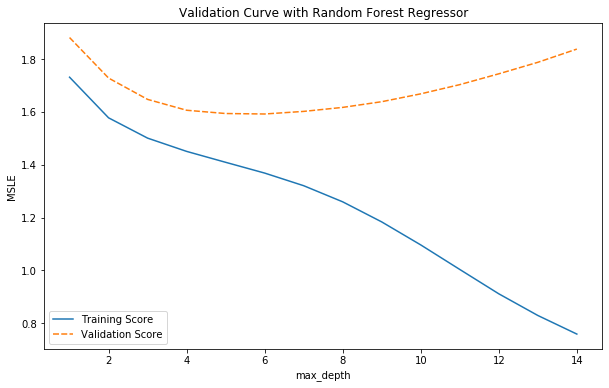

In [233]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Validation Curve with Random Forest Regressor')
ax.set_xlabel(param_name)
ax.set_ylabel('MSLE')
sns.lineplot(data=plot_data)